# calc_clusters

This is the fifth step in reproducing the cluster analysis following [Amini and Straus 2019]
https://doi.org/10.1007/s00382-018-4409-7

This program calculates and plots the composite cluster maps.

* Input: `/glade/work/mkorendy/metisregimes/era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.pcs.nc` and `/glade/work/mkorendy/metisregimes/era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.anoms.nc` and `/glade/work/mkorendy/metisregimes/era5.u250_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.anoms.nc`

* Output: `ERA5_clusters_5_1980-2019_NDJFM.png`, `ERA5_clusters_4_1980-2019_NDJFM.png`, `figs/ERA5_clusters_6_1980-2019_NDJFM.png`
* Output: `/glade/work/mkorendy/metisregimes/era5.NDJFM_k5.centroids.nc`

## Constants

In [1]:
# Months to create cluster composites for
mons = 'NDJFM'

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker


from sklearn.cluster import KMeans
from sklearn import metrics

### Filename and path

In [2]:
path='/glade/work/mkorendy/metisregimes/'
fname='era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.pcs.nc'
met = 'metis.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2016.anoms.nc'

### Read PCs

In [3]:
ds=xr.open_dataset(path+fname)
ds

<xarray.Dataset>
Dimensions:  (pcnum: 12, time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * pcnum    (pcnum) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    pcs      (time, pcnum) float64 ...

In [4]:
ds_m = xr.open_dataset(path + met)
ds_m

<xarray.Dataset>
Dimensions:   (ensemble: 25, lat: 22, lon: 53, time: 8160)
Coordinates:
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time      (time) datetime64[ns] 1986-11-08T12:00:00 ... 2016-03-23
  * lat       (lat) float64 20.93 23.72 26.51 29.3 ... 71.16 73.95 76.74 79.53
  * lon       (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500      (time, ensemble, lat, lon) float64 ...

In [5]:
ds['pcs']

<xarray.DataArray 'pcs' (time: 8160, pcnum: 12)>
array([[ 8.549641, 34.125514, 23.082609, ..., 12.311182, -3.494352,  0.1021  ],
       [ 8.773452, 34.463946, 24.312264, ..., 11.773892, -1.958741,  0.756997],
       [ 8.906806, 34.627695, 25.517118, ..., 10.845344, -0.29626 ,  1.730726],
       ...,
       [-7.04593 , 20.409165, -4.558374, ..., -1.67314 , -2.84884 ,  9.052438],
       [-5.727431, 20.139922, -1.061493, ..., -0.980442, -1.401456,  8.763154],
       [-4.55561 , 19.581929,  2.830356, ..., -0.113276,  0.130896,  7.938948]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * pcnum    (pcnum) int64 0 1 2 3 4 5 6 7 8 9 10 11

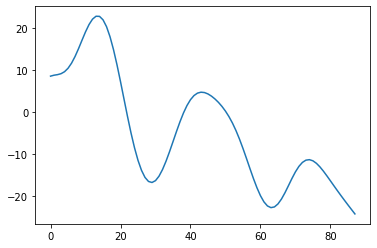

In [6]:
plt.plot(ds['pcs'][0:88,0])

### Read anomalies

In [7]:
fz_anoms='era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc'
fu_anoms = 'era5.u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc'

In [8]:
dsz_anoms=xr.open_dataset(path+fz_anoms)
dsu_anoms = xr.open_dataset(path + fu_anoms)
ds_anoms = xr.merge([dsz_anoms,dsu_anoms])
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...

### KMeans 5

In [9]:
# Apply KMeans to get the clusters centroids
#random_state = random number generation for cluster initialization, integer is deterministic
#init is method of initialization: choose n_clusters observations (rows) at random from data for the initial centroids.
kmeans5 = KMeans(n_clusters=5,random_state=1,init='random',n_init=100)

#(number of samples, number of features) = (time instances, number of pcs)
#returns fitted estimator
kmeans5.fit(ds['pcs'])
labels5 = kmeans5.labels_
metrics.silhouette_score(ds['pcs'], labels5, metric='euclidean')

0.10901776847083675

In [10]:
#Identify the cluster centroids
cents = kmeans5.cluster_centers_
cents = xr.DataArray(cents, coords={'cluster':np.arange(0,5), 'pcs':np.arange(0,12)}, 
             dims={'cluster':np.arange(0,5), 'pcs':np.arange(0,12)})
cents = xr.DataArray.to_dataset(cents, name='k5centroid')
#cents.to_netcdf(path + 'era5.NDJFM_k5.centroids.nc')

In [34]:
# Identify the cluster for each day
# ndarray of shape (nsamples), index of cluster to which each day belongs
y_kmeans5=kmeans5.predict(ds['pcs'])

#Write the cluster index to a text file
k5name = 'era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.nc'
k5file = open(path+k5name,'a')
np.savetxt(k5file,y_kmeans5)
#k5file.write(np.array2string(y_kmeans5))
k5file.close()
print(y_kmeans5)
ds_ykmeans5 = xr.DataArray(y_kmeans5,
                coords={'time':np.arange(len(ds['time']))},
                        dims=['time'])
ds_ykmeans5=ds_ykmeans5.to_dataset(name='k5')
print(ds_ykmeans5)

[1 1 1 ... 3 3 3]
<xarray.Dataset>
Dimensions:  (time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
Data variables:
    k5       (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 3 3 3 3 3


In [35]:
# Re-assign the time dimension to contain the cluster assigned to each day
ds_anoms['time']=y_kmeans5
ds_anoms=ds_anoms.rename({'time':'cluster'})
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 8160, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 3 3 3 3 3
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [36]:
#Take November, December clusters
if mons == 'ND':
    ds_anoms_z = ds_anoms['z500'][(np.argwhere((ds_m['time.month'] >= 11).values))[:,0]]
    ds_anoms_u = ds_anoms['u250'][(np.argwhere((ds_m['time.month'] >= 11).values))[:,0]]
    ds_anoms = xr.merge([ds_anoms_z,ds_anoms_u])

In [37]:
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3210, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 2 2 2
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [38]:
ds_anoms.to_netcdf(path + 'era5.z500_u250_pna_' + mons + '_lpfilter_twicedaily_10days.1986-2015.clust_k5.nc')

### Group the data by the cluster and take the mean over each cluster to get the composites

In [39]:
#composite = average at each grid point (lat,lon) within the day relating to the cluster
cluster_comp=ds_anoms.groupby('cluster').mean()
cluster_comp

<xarray.Dataset>
Dimensions:  (cluster: 5, lat: 22, lon: 53)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * cluster  (cluster) int64 0 1 2 3 4
Data variables:
    z500     (cluster, lat, lon) float64 -391.1 -399.8 -407.5 ... -52.35 -65.78
    u250     (cluster, lat, lon) float64 -2.334 -2.567 ... -0.7097 -0.2812

In [40]:
cluster_comp['z500'][0]

<xarray.DataArray 'z500' (lat: 22, lon: 53)>
array([[-391.08791739, -399.84857054, -407.53314989, ...,  -78.04237875,
         -91.0631423 , -103.92673575],
       [-472.43891033, -487.03142639, -500.09280199, ...,  -45.55899881,
         -64.21978106,  -84.1321027 ],
       [-537.61403308, -558.59049684, -577.31172912, ...,    3.30494724,
         -23.10420832,  -48.90140211],
       ...,
       [ 201.54311635,  220.98320374,  239.80650327, ..., -127.63811841,
        -120.99787843, -110.38605615],
       [ 132.43058258,  143.13218481,  153.56062652, ...,  -88.68048036,
         -79.25262858,  -67.22189682],
       [  69.88705683,   72.45662029,   75.77475657, ...,  -49.20265441,
         -39.25935922,  -28.64561943]])
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
    cluster  int64 0

In [41]:
cluster_comp.to_netcdf(path + 'era5.z500_u250_pna_' + mons + '_lpfilter_twicedaily_10days.1986-2015.comp_k5.nc')

### Calculate the Cluster Frequency

In [42]:
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3210, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 2 2 2
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [43]:
cluster_freq=(ds_anoms.groupby('cluster').count())/len(ds_anoms['cluster'])
cluster_freq['z500'][:,0,0]

<xarray.DataArray 'z500' (cluster: 5)>
array([0.25514019, 0.2105919 , 0.20311526, 0.13925234, 0.19190031])
Coordinates:
    lat      float64 79.53
    lon      float64 151.9
  * cluster  (cluster) int64 0 1 2 3 4

### Set Map Information

In [44]:
cm = 225
proj = ccrs.EquidistantConic(central_longitude=cm)
minlon = -30 + cm
maxlon = +120 + cm
lat_labels=np.arange(20,90,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,20,90]

### Plot the composite cluster maps, reproducing Amini and Straus 2019 Figure 2

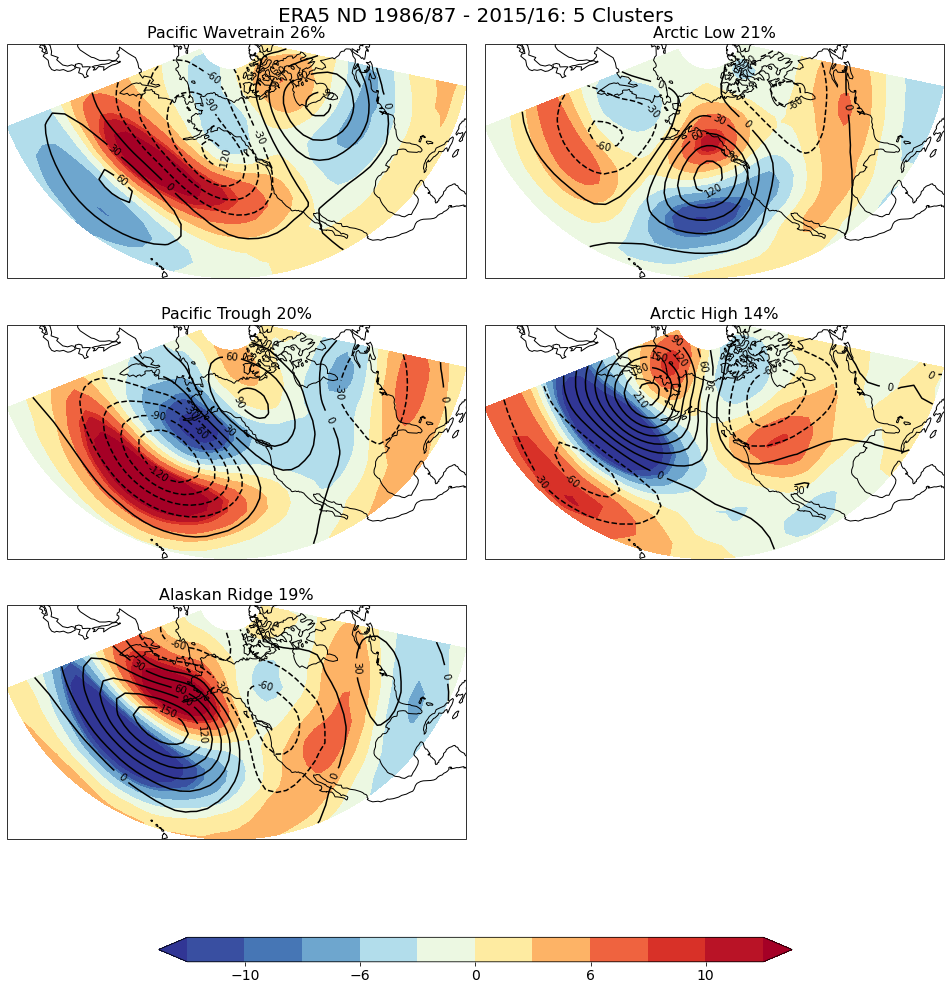

In [46]:
if mons == 'NDJFM':
    titles = ['Arctic Low', 'Pacific Wavetrain', 'Pacific Trough', 'Arctic High', 'Alaskan Ridge']
elif mons == 'ND':
    titles = ['Alaskan Ridge', 'Arctic Low','Pacific Trough', 'Pacific Wavetrain','Arctic High']
    
freq=np.round((cluster_freq['z500'][:,0,0].values)*100)
cm = 220
minlon = -70 + cm
maxlon = 80 + cm
#clevs=np.arange(-12,13,3)
levs=np.arange(-210,220,30)
clevs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
#    ax.set_extent(extent)
    if (i < 5):
        cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                       cluster_comp['u250'][i,:,:],clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r',extend='both')
        cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                   cluster_comp['z500'][i,:,:]/9.81,levs,colors='k',
                   transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i]+' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
        #ax.gridlines()
        ax.coastlines()
fig.delaxes(axs.flatten()[5])    

plt.suptitle('ERA5 ' + mons + ' 1986/87 - 2015/16: 5 Clusters',fontsize=20)
# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.savefig('ERA5.total.clusters_5_1986-2015_' + mons + '.png')

### KMeans 4

In [9]:
kmeans4 = KMeans(n_clusters=4,random_state=1,init='random',n_init=100)
kmeans4.fit(ds['pcs'])
y_kmeans4=kmeans4.predict(ds['pcs'])
labels4 = kmeans4.labels_
metrics.silhouette_score(ds['pcs'], labels4, metric='euclidean')

ds_ykmeans4 = xr.DataArray(y_kmeans4,
                coords={'time':np.arange(len(ds['time']))},
                        dims=['time'])
ds_ykmeans4=ds_ykmeans4.to_dataset(name='k4')

In [10]:
ds_anoms['time']=y_kmeans4

In [11]:
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 8160)
Coordinates:
  * time     (time) int32 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 3 3 3 3 3
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 ...
    u250     (time, lat, lon) float64 ...

In [12]:
#Take November, December clusters
if mons == 'ND':
    ds_anoms_z = ds_anoms['z500'][(np.argwhere((ds_m['time.month'] >= 11).values))[:,0]]
    ds_anoms_u = ds_anoms['u250'][(np.argwhere((ds_m['time.month'] >= 11).values))[:,0]]
    ds_anoms = xr.merge([ds_anoms_z,ds_anoms_u])

In [13]:
ds_anoms=ds_anoms.rename({'time':'cluster'})
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3210, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 3 3 3 3 3 3 3 3 3 3 3 3 ... 0 0 0 0 0 0 0 0 1 1 1 1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [15]:
#composite = average at each grid point (lat,lon) within the day relating to the cluster
cluster_comp=ds_anoms.groupby('cluster').mean()
cluster_comp

<xarray.Dataset>
Dimensions:  (cluster: 4, lat: 22, lon: 53)
Coordinates:
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * cluster  (cluster) int64 0 1 2 3
Data variables:
    z500     (cluster, lat, lon) float64 -302.5 -308.4 -313.8 ... 31.57 24.74
    u250     (cluster, lat, lon) float64 -2.005 -2.185 -2.366 ... -1.938 -1.948

In [16]:
cluster_comp.to_netcdf(path + 'era5.z500_u250_pna_' + mons + '_lpfilter_twicedaily_10days.1986-2015.comp_k4.nc')

In [23]:
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 3210, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 3 3 3 3 3 3 3 3 3 3 3 3 ... 0 0 0 0 0 0 0 0 1 1 1 1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [27]:
cluster_freq=(ds_anoms.groupby('cluster').count())/len(ds_anoms['cluster'])
cluster_freq['z500'][:,0,0]

<xarray.DataArray 'z500' (cluster: 4)>
array([0.32087227, 0.24299065, 0.21869159, 0.21744548])
Coordinates:
  * cluster  (cluster) int64 0 1 2 3
    lat      float64 79.53
    lon      float64 151.9

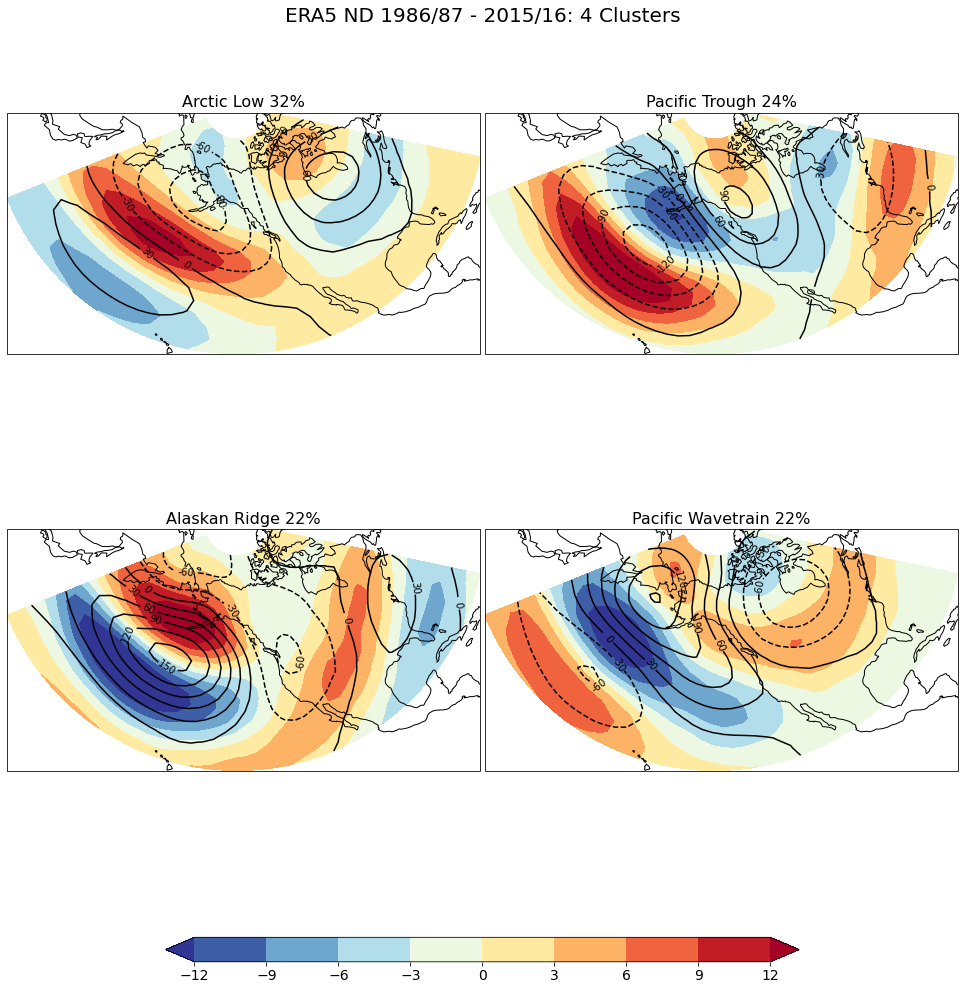

In [30]:
if mons == 'NDFJM':
    titles= ['Arctic Low','Pacific Trough','Alaskan Ridge', 'Pacific Wavetrain']
elif mons == 'ND':
    titles = ['Pacific Wavetrain', 'Alaskan Ridge', 'Arctic Low', 'Pacific Trough']
freq=np.round((cluster_freq['z500'][:,0,0].values)*100)
cm = 220
minlon = -70 + cm
maxlon = 80 + cm
clevs=np.arange(-12,13,3)
celvs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
levs=np.arange(-210,220,30)
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
fig,axs=plt.subplots(2,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
        cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                       cluster_comp['u250'][i,:,:],clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r',extend='both')
        cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                   cluster_comp['z500'][i,:,:]/9.81,levs,colors='k',
                   transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i]+' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
        ax.coastlines() 

plt.suptitle('ERA5 ND 1986/87 - 2015/16: 4 Clusters',fontsize=20)

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.savefig('ERA5.total.clusters_4_1986-2015_ND.png')
#plt.savefig('ERA5_clusters_4_1986-2015_NDJFM.png')

### KMeans 6

In [26]:
kmeans6 = KMeans(n_clusters=6,random_state=1,init='random',n_init=100)
kmeans6.fit(ds['pcs'])
y_kmeans6=kmeans6.predict(ds['pcs'])
labels6 = kmeans6.labels_
print(metrics.silhouette_score(ds['pcs'], labels6, metric='euclidean'))

ds_ykmeans6 = xr.DataArray(y_kmeans6,
                coords={'time':np.arange(len(ds['time']))},
                        dims=['time'])
ds_ykmeans6=ds_ykmeans6.to_dataset(name='k6')

y_kmeans6.shape

0.1041601797379188


(8160,)

In [27]:
ds_anoms['cluster']=y_kmeans6
ds_anoms

<xarray.Dataset>
Dimensions:  (cluster: 8160, lat: 22, lon: 53)
Coordinates:
  * cluster  (cluster) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 0 0 0 0
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (cluster, lat, lon) float64 ...
    u250     (cluster, lat, lon) float64 ...

In [28]:
cluster_comp=ds_anoms.groupby('cluster').mean()
cluster_comp

<xarray.Dataset>
Dimensions:  (cluster: 6, lat: 22, lon: 53)
Coordinates:
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * cluster  (cluster) int64 0 1 2 3 4 5
Data variables:
    z500     (cluster, lat, lon) float64 617.8 642.8 665.9 ... -62.99 -54.67
    u250     (cluster, lat, lon) float64 5.717 6.131 6.519 ... 4.323 4.278 4.189

In [29]:
#cluster_comp.to_netcdf(path + 'era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.comp_k6.nc')

In [30]:
cluster_freq=(ds_anoms.groupby('cluster').count())/len(ds['time'])
print(cluster_freq['z500'][:,0,0])

<xarray.DataArray 'z500' (cluster: 6)>
array([0.12463235, 0.11691176, 0.19963235, 0.17965686, 0.17046569,
       0.20870098])
Coordinates:
    lon      float64 151.9
    lat      float64 79.53
  * cluster  (cluster) int64 0 1 2 3 4 5


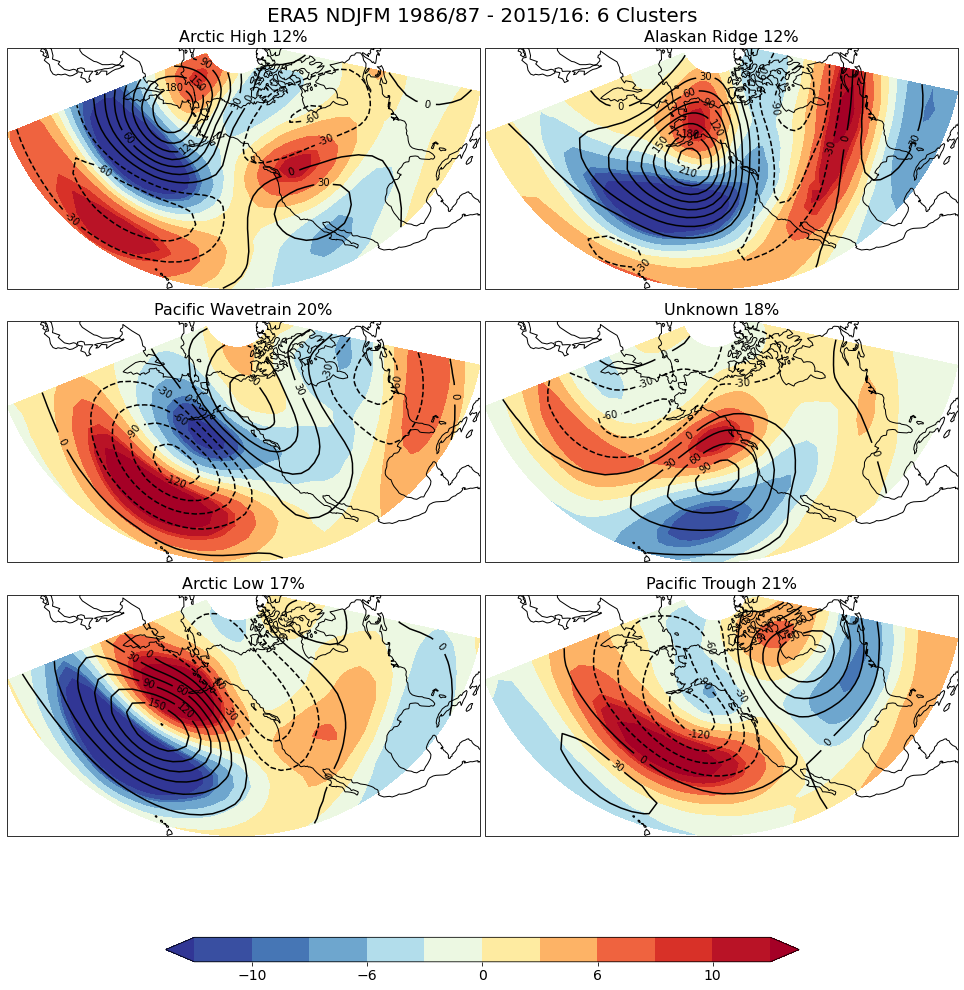

In [31]:
titles=['Arctic High','Alaskan Ridge','Pacific Wavetrain','Unknown','Arctic Low','Pacific Trough',]
freq=np.round((cluster_freq['z500'][:,0,0].values)*100)
cm = 220
minlon = -70 + cm
maxlon = 80 + cm
clevs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
levs=np.arange(-210,220,30)
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
        cs=ax.contourf(cluster_comp['lon'],cluster_comp['lat'],
                       cluster_comp['u250'][i,:,:],clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r',extend='both')
        cs2=ax.contour(cluster_comp['lon'],cluster_comp['lat'],
                   cluster_comp['z500'][i,:,:]/9.81,levs,colors='k',
                   transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i]+' '+str(np.int(freq[i]))+'%',fontdict={'fontsize':16})
        ax.coastlines() 

plt.suptitle('ERA5 NDJFM 1986/87 - 2015/16: 6 Clusters',fontsize=20)

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

plt.savefig('ERA5_clusters_6_1986-2015_' + mons + '.png')

In [36]:
#Save the cluster indices to a file:
ds_cluster =xr.merge([ds_ykmeans4,ds_ykmeans5,ds_ykmeans6])
print(ds_cluster)

ds_cluster.to_netcdf(path + 'era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.cluster.nc')

<xarray.Dataset>
Dimensions:  (time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
Data variables:
    k4       (time) int32 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 1 1 1 1 1 1 1 3 3 3 3 3
    k5       (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 3 3 3 3 3
    k6       (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 0 0 0 0
